This notebook follows 2.2_apply_clustering_on_knn_graph.

Inputs:
1. big_clusters_expression.csv
2. retina_clusteridentities.txt

In [1]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
from matplotlib.colors import rgb2hex
import seaborn as sns

# Bokeh - interactive plotting in the browser
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.models.widgets import Panel, Tabs
from bokeh.layouts import widgetbox
from bokeh.io import output_notebook
output_notebook()  # required for bokeh plots to appear in the notebooks

import networkx
import phenograph   # K-nearest neighbors cell clustering from Dana Pe'er's lab

from functions.data import ClusterToCellType
from functions.colors import generate_label_colors
from functions.plotting import plot_network

%matplotlib inline

Loading BokehJS ...

# Get Data

In [2]:
expression = pd.read_csv('data/big_clusters/big_clusters_expression.csv', index_col=0)

cell_metadata = pd.read_csv('data/downloads/retina_clusteridentities.txt',
                            sep='\t', header=None, names=['cell', 'cluster_no'], index_col=0)

cluster_to_celltype = ClusterToCellType()
cell_metadata = cell_metadata.join(cluster_to_celltype.dataframe.set_index('cluster_no'), on='cluster_no')
cell_metadata

,cluster_no,cell_type,cluster_id
cell,,,
r1_GGCCGCAGTCCG,2,Retinal ganglion cells,cluster_02
r1_CTTGTGCGGGAA,2,Retinal ganglion cells,cluster_02
r1_GCGCAACTGCTC,2,Retinal ganglion cells,cluster_02
r1_GATTGGGAGGCA,2,Retinal ganglion cells,cluster_02
r1_GTGCCGCCTCTC,25,Cones,cluster_25
...,...,...,...
p1_TCAAAAGCCGGG,24,Rods,cluster_24
p1_ATTAAGTTCCAA,34,Muller glia,cluster_34
p1_CTGTCTGAGACC,2,Retinal ganglion cells,cluster_02


# Correlation Matrix

In [3]:
corr_df = expression.T.rank().corr()
print(corr_df.shape)
corr_df.head()

(300, 300)


,r1_CGCACTAGAAGG,r1_CATAGAGACCGC,r1_GTCAAACTTAGG,r1_ATCCAATGCGCC,r1_GAGGTTCATACA,r1_GGCGAGCGGAAG,r1_GGTCTTTGAACG,r1_TAAATGTTCTCA,r1_TCCATCTCGCTT,r1_AGAGTATGTTGT,...,r1_TATAGGAACAAA,r1_GCGGGCGATCGC,r1_TGCTAGTTTCAC,r1_TTGCTGAAGGGC,r1_AGCAATATCAAT,r1_AAAATATGTTAC,r1_GCCGTATTAAGA,r1_AAACCAAGAAGG,r1_GAATTCATAACC,r1_TTGGGGTGAGTA
r1_CGCACTAGAAGG,1.000000,0.642391,0.597699,0.701254,0.537004,0.554224,0.685422,0.552749,0.522867,0.630393,...,-0.069589,-0.001186,0.012542,-0.075848,-0.096439,-0.141208,-0.170923,-0.025599,-0.085410,-0.019241
r1_CATAGAGACCGC,0.642391,1.000000,0.555670,0.611511,0.553391,0.467414,0.599112,0.468355,0.431994,0.594436,...,-0.094710,-0.043876,0.017054,-0.042467,-0.068886,-0.161946,-0.188026,-0.008802,-0.078409,0.006798
r1_GTCAAACTTAGG,0.597699,0.555670,1.000000,0.639177,0.564557,0.527850,0.630595,0.498305,0.534076,0.588441,...,-0.018229,-0.002728,0.051390,-0.044632,-0.072961,-0.188096,-0.126866,-0.051938,-0.089260,-0.036518
r1_ATCCAATGCGCC,0.701254,0.611511,0.639177,1.000000,0.608853,0.621036,0.729100,0.526116,0.514917,0.639032,...,-0.005812,0.006636,-0.018421,-0.046677,-0.058203,-0.121081,-0.113116,-0.062186,-0.054227,-0.012775
r1_GAGGTTCATACA,0.537004,0.553391,0.564557,0.608853,1.000000,0.450781,0.582813,0.405726,0.465667,0.592562,...,-0.055677,-0.038405,0.048312,-0.035908,-0.113393,-0.205389,-0.159570,-0.060144,-0.077199,-0.000454


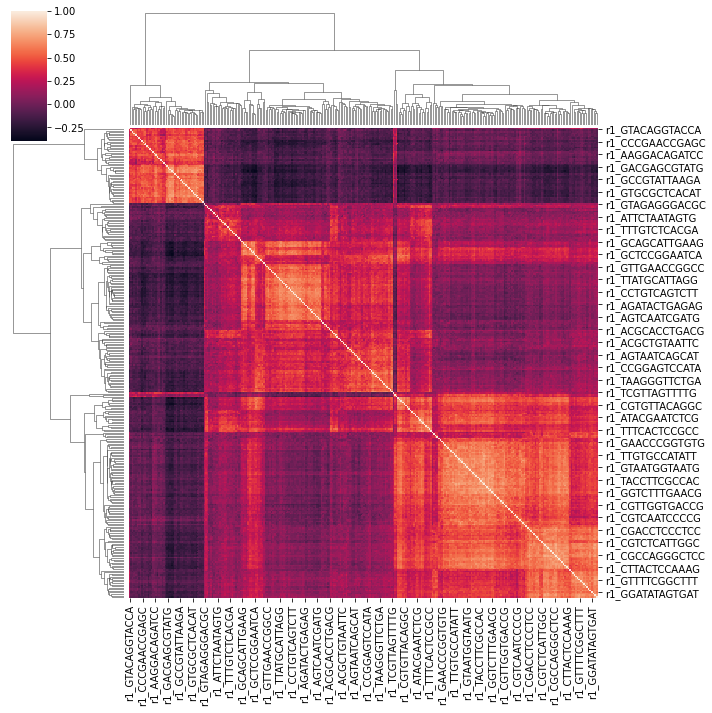

In [4]:
sns.clustermap(corr_df)

/home/harrisonized/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

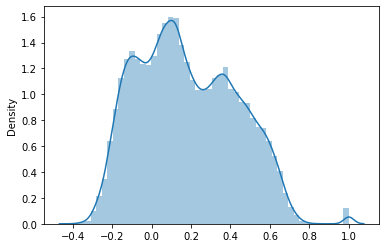

In [5]:
sns.distplot(corr_df.values.flat)

# Pearson Distance Metric

In [6]:
# correlation_to_distance
# define distance = sqrt(2*(1-corr))
distances = corr_df.apply(lambda corr: np.sqrt(2*(1-corr)))
distances.head()

,r1_CGCACTAGAAGG,r1_CATAGAGACCGC,r1_GTCAAACTTAGG,r1_ATCCAATGCGCC,r1_GAGGTTCATACA,r1_GGCGAGCGGAAG,r1_GGTCTTTGAACG,r1_TAAATGTTCTCA,r1_TCCATCTCGCTT,r1_AGAGTATGTTGT,...,r1_TATAGGAACAAA,r1_GCGGGCGATCGC,r1_TGCTAGTTTCAC,r1_TTGCTGAAGGGC,r1_AGCAATATCAAT,r1_AAAATATGTTAC,r1_GCCGTATTAAGA,r1_AAACCAAGAAGG,r1_GAATTCATAACC,r1_TTGGGGTGAGTA
r1_CGCACTAGAAGG,0.000000,0.845706,0.896996,0.772976,0.962285,0.944220,0.793193,0.945781,0.976866,0.859775,...,1.462593,1.415052,1.405317,1.466866,1.480837,1.510766,1.530309,1.432200,1.473370,1.427754
r1_CATAGAGACCGC,0.845706,0.000000,0.942688,0.881463,0.945102,1.032072,0.895419,1.031159,1.065839,0.900626,...,1.479669,1.444906,1.402103,1.443930,1.462112,1.524432,1.541445,1.420424,1.468611,1.409398
r1_GTCAAACTTAGG,0.896996,0.942688,0.000000,0.849497,0.933212,0.971751,0.859540,1.001694,0.965322,0.907259,...,1.427045,1.416141,1.377396,1.445429,1.464896,1.541490,1.501243,1.450474,1.475981,1.439804
r1_ATCCAATGCGCC,0.772976,0.881463,0.849497,0.000000,0.884474,0.870590,0.736071,0.973534,0.984970,0.849668,...,1.418317,1.409513,1.427180,1.446843,1.454787,1.497385,1.492056,1.457522,1.452051,1.423218
r1_GAGGTTCATACA,0.962285,0.945102,0.933212,0.884474,0.000000,1.048064,0.913440,1.090206,1.033763,0.902705,...,1.453050,1.441114,1.379629,1.439380,1.492242,1.552668,1.522873,1.456121,1.467787,1.414535


/home/harrisonized/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

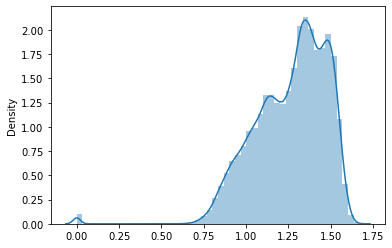

In [7]:
sns.distplot(distances.values.flat)

# Phenograph Clustering

In [8]:
communities, sparse_matrix, Q = phenograph.cluster(distances, k=10)

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.12221479415893555 seconds
Jaccard graph constructed in 0.11521005630493164 seconds
Wrote graph to binary file in 0.010078907012939453 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.861597
Louvain completed 21 runs in 0.29381442070007324 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 0.8216843605041504 seconds


## Node Specs

In [9]:
np.random.seed(seed=42)

# Use networkx to build graph in 2D and lay out the cells and edges
graph = networkx.from_scipy_sparse_matrix(sparse_matrix)

# Use spring node_specs to push cells and edges away from each other
# See: https://networkx.org/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
positions = networkx.spring_layout(graph)

node_specs = pd.DataFrame(positions, index=['xs', 'ys']).T  # Convert positions dict to dataframe with node information
node_specs['community'] = communities  # label positions with community number
node_specs['cell'] = distances.index
node_specs = node_specs.join(cell_metadata, on='cell', how='left')  # add cell cluster numbers

# label colors
label_colors = generate_label_colors(node_specs['cluster_id'].unique(),
                                     sns.color_palette(palette='Set2'))
node_specs['cluster_color'] = node_specs['cluster_id'].apply(lambda x: rgb2hex(label_colors[x]))

label_colors = generate_label_colors(node_specs['community'].unique(),
                                     sns.color_palette(palette='Set2'))
node_specs['community_color'] = node_specs['community'].apply(lambda x: rgb2hex(label_colors[x]))

node_specs  # also named node_specs

,xs,ys,community,cell,cluster_no,cell_type,cluster_id,cluster_color,community_color
0,-0.847520,-0.068194,0,r1_CGCACTAGAAGG,24,Rods,cluster_24,#66c2a5,#66c2a5
1,-0.791175,0.069027,0,r1_CATAGAGACCGC,24,Rods,cluster_24,#66c2a5,#66c2a5
2,-0.886185,0.120430,0,r1_GTCAAACTTAGG,24,Rods,cluster_24,#66c2a5,#66c2a5
3,-0.892552,-0.047465,0,r1_ATCCAATGCGCC,24,Rods,cluster_24,#66c2a5,#66c2a5
4,-0.754306,0.180073,0,r1_GAGGTTCATACA,24,Rods,cluster_24,#66c2a5,#66c2a5
...,...,...,...,...,...,...,...,...,...
295,0.930961,0.015780,4,r1_AAAATATGTTAC,34,Muller glia,cluster_34,#ffd92f,#66c2a5
296,0.977819,0.073999,4,r1_GCCGTATTAAGA,34,Muller glia,cluster_34,#ffd92f,#66c2a5
297,0.820550,0.384772,7,r1_AAACCAAGAAGG,34,Muller glia,cluster_34,#ffd92f,#fc8d62
298,0.916085,0.111754,4,r1_GAATTCATAACC,34,Muller glia,cluster_34,#ffd92f,#66c2a5


# Edge Specs

In [10]:
edge_specs = pd.DataFrame(columns=['xs', 'ys', 'alphas'],
                  index=range(len(graph.edges())))
weights = [d['weight'] for u, v, d in graph.edges(data=True)]
max_weight = max(weights)
calc_alpha = lambda h: 0.1 + 0.6 * (h / max_weight)

# example: { ..., ('user47', 'da_bjoerni', {'weight': 3}), ... }
for i, (u, v, data) in enumerate(graph.edges(data=True)):
    # Assign 'xs' column
    edge_specs.iloc[i, 0] = [positions[u][0], positions[v][0]]
    # Assign 'ys' column
    edge_specs.iloc[i, 1] = [positions[u][1], positions[v][1]]
    # Assign 'alphas' column
    edge_specs.iloc[i, 2] = calc_alpha(data['weight'])
edge_specs

,xs,ys,alphas
0,"[-0.8475204268128469, -0.892552100184072]","[-0.06819404046535496, -0.04746530368914026]",0.414286
1,"[-0.8475204268128469, -0.8607515841644229]","[-0.06819404046535496, -0.10248044748956532]",0.257143
2,"[-0.8475204268128469, -0.8755795125323864]","[-0.06819404046535496, 0.021416209448577535]",0.191667
3,"[-0.8475204268128469, -0.8835767927248112]","[-0.06819404046535496, -0.07742647816319821]",0.344444
4,"[-0.8475204268128469, -0.9229917449516518]","[-0.06819404046535496, -0.021903061320734118]",0.191667
...,...,...,...
2020,"[0.8611343270419345, 0.9160853608692147]","[0.1448251154737505, 0.11175428142357563]",0.191667
2021,"[0.8611343270419345, 0.8615198788092414]","[0.1448251154737505, 0.26076575340795427]",0.181481
2022,"[0.8791143436633652, 0.9160853608692147]","[0.10260787552433397, 0.11175428142357563]",0.344444
2023,"[0.8791143436633652, 0.8615198788092414]","[0.10260787552433397, 0.26076575340795427]",0.140741


To be able to use the dataframes with the Bokeh plotting language, we need to convert our dataframes into `ColumnDataSource` objects.

In [11]:
node_source = ColumnDataSource(node_specs)
edge_source = ColumnDataSource(edge_specs)

community_fig = plot_network('xs', 'ys',
                             node_source, edge_source,
                             group_col='community', color_col='community_color',
                             title='Community')
community_tab = Panel(child=community_fig, title='Community')

cluster_fig = plot_network('xs', 'ys',
                           node_source, edge_source,
                           group_col='cluster_no', color_col='cluster_color',
                           title='Clusters')
cluster_tab = Panel(child=cluster_fig, title='Clusters')

tabs = Tabs(tabs=[community_tab, cluster_tab])
show(tabs)